In [ ]:
!pip install deap matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 10.0 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import random
import operator
import math
import matplotlib.pyplot as plt
from deap import algorithms, base, creator, tools, gp

# Define the primitive set for symbolic expressions
pset = gp.PrimitiveSet("MAIN", 1)  # 1 argument (x)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1, 1))  # Random constants
pset.renameArguments(ARG0='x')  # Rename input to 'x'


/usr/local/lib/python3.12/dist-packages/deap/gp.py:257: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


In [ ]:
# Create fitness and individual classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize fitness (error)
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# Toolbox for GP operations
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


In [ ]:
# Target function to approximate: y = x^2 + 2x + 1
def target_func(x):
    return x**2 + 2*x + 1

# Evaluation function: compute MSE
def evalSymbReg(individual, points):
    func = toolbox.compile(expr=individual)
    mse = sum((func(x) - target_func(x))**2 for x in points) / len(points)
    return mse,

# Register evaluation
toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10, 10)])  # Sample points from -1 to 1


In [ ]:
# Genetic operators
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)  # Crossover
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# Limits to prevent bloat
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))


In [ ]:
def main():
    random.seed(42)
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    # For fitness, always extract first element from tuples
    mstats.register("avg", lambda vals: sum(v[0] if isinstance(v, tuple) else v for v in vals)/len(vals) if vals else 0)
    mstats.register("min", lambda vals: min(v[0] if isinstance(v, tuple) else v for v in vals) if vals else 0)

    pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats, halloffame=hof, verbose=True)
    return pop, log, hof

# Run it
pop, log, hof = main()


   	      	           fitness            	             size             
   	      	------------------------------	------------------------------
gen	nevals	avg 	gen	min    	nevals	avg 	gen	min	nevals
0  	300   	3.53	0  	0.20333	300   	3.99	0  	2  	300   
1  	159   	2.66267	1  	0.20333	159   	3.91	1  	1  	159   
2  	154   	2.34772	2  	0.20333	154   	4.22667	2  	1  	154   
3  	172   	1.87065	3  	0.20333	172   	4.39   	3  	1  	172   
4  	165   	1.89725	4  	0.20333	165   	4.93   	4  	1  	165   
5  	170   	1.39577	5  	1.26437e-32	170   	5.22   	5  	1  	170   
6  	164   	1.34498	6  	1.26437e-32	164   	5.72667	6  	1  	164   
7  	172   	1.27829	7  	1.26437e-32	172   	6.07   	7  	1  	172   
8  	152   	1.11503	8  	1.26437e-32	152   	6.27   	8  	1  	152   
9  	150   	1.04682	9  	0.0761805  	150   	6.60667	9  	1  	150   
10 	154   	0.877157	10 	1.26437e-32	154   	7.03667	10 	1  	154   
11 	171   	1.28245 	11 	1.04771e-32	171   	7.62667	11 	1  	171   
12 	190   	1.12738 	12 	1.04771e-32	190   	8.2

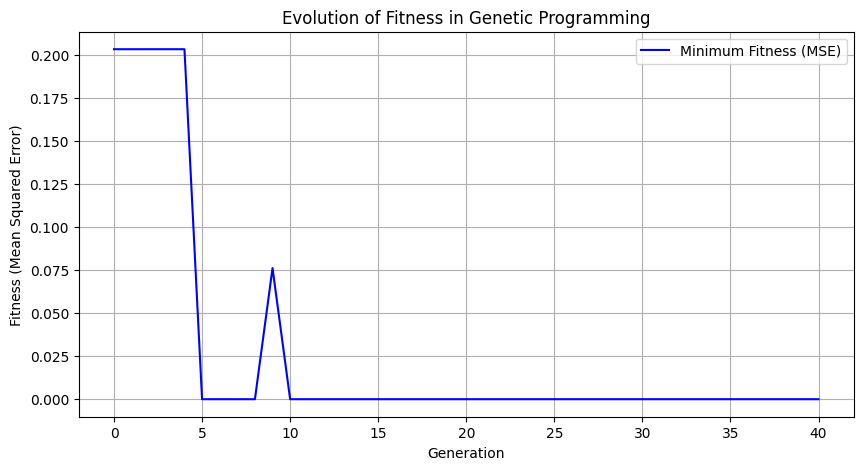

In [ ]:
# Extract data for graph
gen = log.select("gen")
min_fit = log.chapters["fitness"].select("min")

# Plot fitness over generations
plt.figure(figsize=(10, 5))
plt.plot(gen, min_fit, label="Minimum Fitness (MSE)", color='blue')
plt.xlabel("Generation")
plt.ylabel("Fitness (Mean Squared Error)")
plt.title("Evolution of Fitness in Genetic Programming")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Best individual
best = hof[0]
print("Best Evolved Expression:", best)

# Compile and test
func = toolbox.compile(expr=best)
test_points = [-1.0, -0.5, 0.0, 0.5, 1.0]
print("\nTest Results (x | Target | Evolved):")
for x in test_points:
    target = target_func(x)
    evolved = func(x)
    print(f"{x:.1f} | {target:.2f} | {evolved:.2f} (Error: {abs(target - evolved):.2f})")


Best Evolved Expression: add(add(x, sub(mul(x, x), mul(-1, x))), 1)

Test Results (x | Target | Evolved):
-1.0 | 0.00 | 0.00 (Error: 0.00)
-0.5 | 0.25 | 0.25 (Error: 0.00)
0.0 | 1.00 | 1.00 (Error: 0.00)
0.5 | 2.25 | 2.25 (Error: 0.00)
1.0 | 4.00 | 4.00 (Error: 0.00)


Best Evolved Expression: add(add(x, sub(mul(x, x), mul(-1, x))), 1)

Test Results (x | Target | Evolved):
-1.0 | 0.00 | 0.00 (Error: 0.00)
-0.5 | 0.25 | 0.25 (Error: 0.00)
0.0 | 1.00 | 1.00 (Error: 0.00)
0.5 | 2.25 | 2.25 (Error: 0.00)
1.0 | 4.00 | 4.00 (Error: 0.00)


/tmp/ipython-input-1345422903.py:34: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_points,


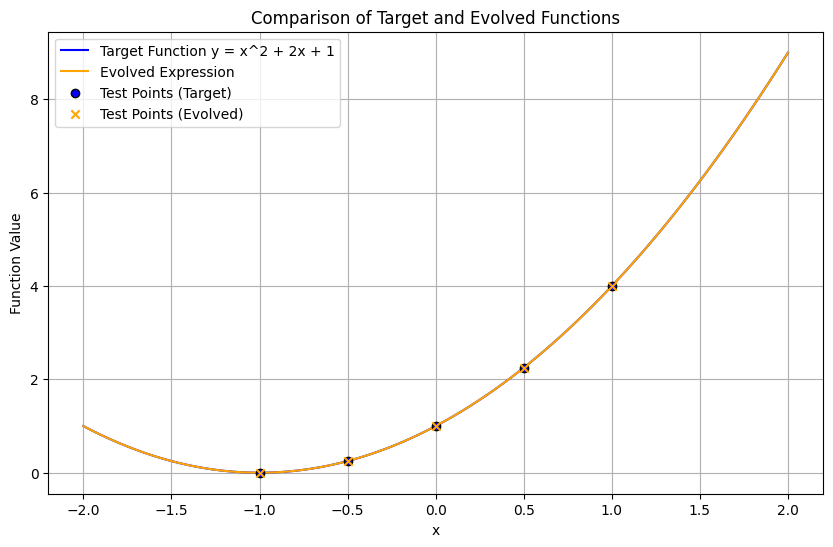

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Best individual
best = hof[0]
print("Best Evolved Expression:", best)

# Compile the best evolved program
func = toolbox.compile(expr=best)

# Test points where you want to see results
test_points = [-1.0, -0.5, 0.0, 0.5, 1.0]

print("\nTest Results (x | Target | Evolved):")
for x in test_points:
    target = target_func(x)
    evolved = func(x)
    print(f"{x:.1f} | {target:.2f} | {evolved:.2f} (Error: {abs(target - evolved):.2f})")

# Prepare data for plotting
x_vals = np.linspace(-2, 2, 100)  # smooth curve range
target_vals = [target_func(x) for x in x_vals]
evolved_vals = [func(x) for x in x_vals]

# Plotting both functions
plt.figure(figsize=(10, 6))
plt.plot(x_vals, target_vals, label='Target Function y = x^2 + 2x + 1', color='blue')
plt.plot(x_vals, evolved_vals, label='Evolved Expression', color='orange')

# Mark the test points on the plot
plt.scatter(test_points,
            [target_func(x) for x in test_points],
            color='blue', edgecolor='black', zorder=5, label='Test Points (Target)')
plt.scatter(test_points,
            [func(x) for x in test_points],
            color='orange', edgecolor='black', zorder=5, label='Test Points (Evolved)', marker='x')

# Graph settings
plt.title("Comparison of Target and Evolved Functions")
plt.xlabel("x")
plt.ylabel("Function Value")
plt.legend()
plt.grid(True)
plt.show()
